In [101]:
import pandas as pd
import sqlalchemy
from routes import routes
from utils import graph_utils, station_manager, visualization_utils
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import folium
from folium import FeatureGroup
import geopandas as gpd
from shapely.geometry import LineString
from shapely.wkt import loads

In [102]:
# import stations
stations = routes.extracts('../data/processed/stations.gpkg')
remover = routes.select_criteria(stations) # filter stations (same criteria as routes)
stations = station_manager.remove_stations(stations, remover) # remover as estações deletadas; aqui tem que ser o mesmo critério de routes
# make graph
G = graph_utils.generate_graph(stations)

# remove todas as estações sem geometria
stations.reset_index(inplace=True, drop=True)
remover_2 = stations[stations['points_geometry'].isna()]['estacao'].unique().tolist()
stations = station_manager.remove_stations(stations, remover_2)

In [103]:
engine = sqlalchemy.create_engine('sqlite:///../data/processed/database.db')

def import_query(file_path):
    with open(file_path, 'r') as file:
        return file.read()

query = """SELECT 
    o.data,
    o.id,
    o.TU,
    o.ValorTKU,
    f.ferrovia,
    f.cliente,
    f.mercadoria,
    f.origem,
    f.destino,
    f.dist_media,
    f.intermed,
    f.len_Dijkstra,
    f.rota
FROM 
    ocorrencias o
LEFT JOIN 
    fluxos_rotas_2017 f
ON 
    o.id = f.id
WHERE 
    o.data >= '2024-01-01' and o.data <= '2024-12-01';
"""
fluxos = pd.read_sql(query, engine)

In [104]:
def nodes_to_edges(df):

    # Verificar monotonicidade em cada grupo
    for name, group in df.groupby('linha'):
        if not group['sequencia'].is_monotonic_increasing:
            print(f'sequencia not increasing in linha {name}')
            return None
    
    edges = df.copy()
    edges['estacao_anterior'] = edges['estacao'].shift()
    edges['geometry_anterior'] = edges['points_geometry'].shift() # essa tem que ser a points_geometry
    edges = edges[edges['sequencia'] != 1].reset_index(drop=True)
    edges['sequencia'] -= 1


    return edges

edges = nodes_to_edges(stations)

edges = edges[['ferrovia','linha','estacao_anterior','estacao', 'sequencia', 'extensao', 'geometry_anterior','points_geometry']].copy()
edges

,ferrovia,linha,estacao_anterior,estacao,sequencia,extensao,geometry_anterior,points_geometry
0,RMP,Alça Alumínio-Capricórnio,ZAL,ZPS,1,4.700,POINT (-47.258995 -23.536671),POINT (-47.228199 -23.533678)
1,RMP,Alça Boa Vista Nova - Boa Vista Velha,ZBL,ZBV,1,1.300,POINT (-47.139936 -22.877123),POINT (-47.142709 -22.886679)
2,RMP,Alça Canguera,ZMK,ZKE,1,6.700,POINT (-47.183361 -23.544556),POINT (-47.17005 -23.572923)
3,RMP,Alça Pantojo-Capricórnio,ZXY,ZPS,1,0.750,POINT (-47.23033 -23.541505),POINT (-47.228199 -23.533678)
4,RMP,Alça de Campinas,ZBL,Z51,1,1.960,POINT (-47.139936 -22.877123),POINT (-47.134899 -22.889949)
...,...,...,...,...,...,...,...,...
1889,EFVM,Ramal de Fábrica,VRV,VFU,14,14.868,POINT (-43.519584 -20.314082),POINT (-43.624992 -20.369007)
1890,EFVM,Ramal de Fábrica,VFU,VCB,15,8.088,POINT (-43.624992 -20.369007),POINT (-43.675861 -20.411174)
1891,EFVM,Ramal de Fábrica,VCB,ELF,16,9.159,POINT (-43.675861 -20.411174),POINT (-43.747216 -20.436445)
1892,EFVM,Ramal de Fábrica,ELF,VFM,17,13.062,POINT (-43.747216 -20.436445),POINT (-43.846753 -20.416289)


In [105]:
def calculate_tu(row):
    _, path = graph_utils.must_pass(G, [row.estacao_anterior, row.estacao])
    x = fluxos.apply(lambda r: graph_utils.find_tu(G, r['rota'], path, r['TU'], row.ferrovia), axis=1).sum()
    return x

# Apply the function with a progress bar
edges['TU'] = [calculate_tu(row) for row in tqdm(edges.itertuples(index=False), total=len(edges))] # 13 minutos


  0%|          | 0/1894 [00:00<?, ?it/s]

100%|██████████| 1894/1894 [15:51<00:00,  1.99it/s]


In [106]:
# unite geometry:
edges['geometry'] = edges.apply(lambda x: LineString([loads(point).coords[0] for point in [x['geometry_anterior'], x['points_geometry']] if point is not None]) 
                                     if pd.notnull(x['geometry_anterior']) and pd.notnull(x['points_geometry']) else None,
                                     axis=1)

In [107]:
# calculate percentiles:
non_zeros_values = edges[edges['TU'] != 0]['TU']#.unique()
zeros = edges[edges['TU'] == 0].copy()
non_zeros = edges[edges['TU'] != 0].copy()

# Calculando percentis
percentis_bins = 20
percentis = non_zeros_values.quantile([i / percentis_bins for i in range(1, percentis_bins + 1)])
non_zeros['percentil'] = pd.cut(non_zeros['TU'], bins=[-1] + list(percentis), labels=[i for i in range(1, percentis_bins + 1)])
print(percentis)

0.05        51552.0
0.10       239844.0
0.15       292555.0
0.20       389034.0
0.25       630227.0
0.30       857031.0
0.35      1468668.0
0.40      1752086.0
0.45      2101752.0
0.50      2798580.0
0.55      3492940.0
0.60      5088194.0
0.65      6978639.0
0.70     11540195.0
0.75     13925049.0
0.80     29116858.0
0.85     42757192.0
0.90     57849017.0
0.95     86927886.0
1.00    174466755.0
Name: TU, dtype: float64


{1: '#ffffcc', 2: '#fff8ba', 3: '#fff0a8', 4: '#ffe895', 5: '#fee084', 6: '#fed572', 7: '#fec561', 8: '#feb44e', 9: '#fea546', 10: '#fd953f', 11: '#fd8038', 12: '#fc6430', 13: '#fb4b29', 14: '#f03523', 15: '#e61f1d', 16: '#d6111f', 17: '#c70723', 18: '#b20026', 19: '#990026', 20: '#800026'}


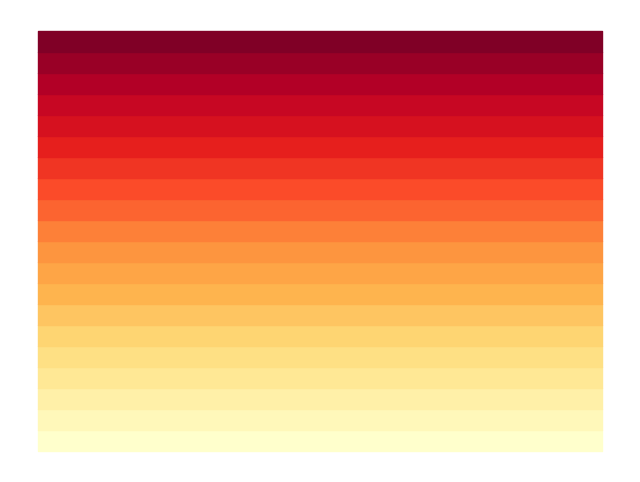

In [108]:
# Obter colormap Spectral
cmap = plt.cm.YlOrRd

# Número de cores a serem extraídas
num_colors = 20
hexcodes = [rgb2hex(cmap(i / (num_colors - 1))) for i in range(num_colors)]
hex_dict = {i + 1: hexcodes[i] for i in range(len(hexcodes))}

print(hex_dict)

# show the colors:
plt.figure(figsize=(8, 6))
for i, color in enumerate(hexcodes):
    plt.fill_between([0, 1], i, i + 1, color=color)
plt.gca().axis('off')
plt.show()

In [109]:
# cores da escala escolhida:
non_zeros['cores'] = non_zeros['percentil'].map(hex_dict)
zeros['cores'] = '#000000' # preto para zeros

# cores do SAFF GEO
cor_ferrovia = {'EFC': '#92A179','EFPO': '#AFCC48','EFVM': '#E58634','FCA': '#517EB2',
                'FNSTC': '#652B0E','FNSTN': '#2012A8','FTC': '#EDC17C', 
                'FTL': '#BE85D3','MRS': '#5D9D40','RMC': '#652B0E',
                'RMN': '#CC3964','RMO': '#EECC58','RMP': '#633FB0','RMS': '#CD7B81'}

# map dict cores para criar a coluna cores no dataframe:
edges['cor_ferrovia'] = edges['ferrovia'].map(cor_ferrovia)

In [112]:
# mapa com informação

# Criar um mapa base centrado em uma localização específica
latitude = -14.2350
longitude = -51.9253
m = folium.Map(location=[latitude, longitude], zoom_start=5)

# Criar camadas
layer1 = FeatureGroup(name='Trechos sem tráfego')
layer2 = FeatureGroup(name='Malha completa')

# Iterar sobre as linhas do GeoDataFrame trechos_geometry e adicionar ao mapa
for _, row in zeros.iterrows():
    # Extrair as coordenadas da geometria LineString
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Obter a cor da linha
    color = row['cores']
    # Obter o rótulo da linha
    label = row['linha']
    # Adicionar a linha ao mapa com a cor específica e um tooltip
    folium.PolyLine(coords, color=color, weight=5.0, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer1)


# Iterar sobre as linhas do outro GeoDataFrame outra_geometry e adicionar ao mapa
for _, row in edges.iterrows():
    # Extrair as coordenadas da geometria LineString
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Obter a cor da linha
    color = row['cor_ferrovia']
    # Obter o rótulo da linha
    label = row['linha']
    # Adicionar a linha ao mapa com a cor específica e um tooltip
    folium.PolyLine(coords, color=color, weight=2.5, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer2)

# Adicionar camadas ao mapa
layer1.add_to(m)
layer2.add_to(m)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Criar uma legenda personalizada
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 120px; height: 360px; 
            border:2px solid grey; z-index:9999; font-size:12px;
            background-color:white; opacity: 0.8; overflow-y: auto;">
    <p style="margin: 10px;"><b>Legenda</b></p>
'''

# Adicionar entradas de legenda dinamicamente
for ferrovia, cor in cor_ferrovia.items():
    legend_html += f'''
    <p style="margin: 5px;">
        <i style="background:{cor}; width: 10px; height: 10px; float: left; margin-right: 5px;"></i>
        {ferrovia}
    </p>
    '''

legend_html += '</div>'

# Adicionar a legenda ao mapa
m.get_root().html.add_child(folium.Element(legend_html))

# Exibir o mapa
m.save('malha_ferroviária.html')

# Heatmap

In [113]:
# Criar um mapa base centrado em uma localização específica
latitude = -14.2350
longitude = -51.9253
m = folium.Map(location=[latitude, longitude], zoom_start=5)

# Criar camadas
layer1 = FeatureGroup(name='Trechos sem tráfego')
layer2 = FeatureGroup(name='Heatmap')

for _, row in zeros.iterrows(): # adicinar linhas à camada
    coords = [(point[1], point[0]) for point in row.geometry.coords] # extrair coordenadas da linha
    color = row['cores']# cor da linha
    label = row['linha'] # rótulo da linha
    # Adicionar a linha ao mapa com a cor específica e um tooltip
    folium.PolyLine(coords, color=color, weight=5.0, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer1)


for _, row in non_zeros.iterrows():
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    color = row['cores']
    label = row['linha']
    folium.PolyLine(coords, color=color, weight=2.5, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer2)

# Adicionar camadas ao mapa
layer1.add_to(m)
layer2.add_to(m)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Criar legenda
cmap = plt.cm.YlOrRd # Obter colormap YlOrRd

# Valores de TU que baseiam as cores (exemplo: de 0 a 100 com 20 divisões)
tu_values = list(range(0, 101, 5))  # Modifique conforme sua necessidade
norm = plt.Normalize(vmin=min(tu_values), vmax=max(tu_values))  # Normalização

# Criar uma função mapeando TU -> cor
hexcodes = [rgb2hex(cmap(norm(tu))) for tu in tu_values]

# Criar uma legenda personalizada com gradiente
gradient_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 300px; height: 25px; 
            border:2px solid grey; z-index:9999; font-size:12px;
            background: linear-gradient(to right, {colors});
            padding: 5px;">
    <div style="display: flex; justify-content: space-between;">
        <span>{min_val}</span>
        <span>{max_val}</span>
    </div>
</div>
'''

# Preparar os parâmetros do gradiente
color_stops = ', '.join(hexcodes)  # Lista de cores no gradiente
gradient_html = gradient_html.format(
    colors=color_stops, min_val=min(tu_values), max_val=max(tu_values)
)

# Adicionar o gradiente como legenda ao mapa
m.get_root().html.add_child(folium.Element(gradient_html))

# Salvar o mapa
m.save('heat_map_with_gradient.html')

In [114]:
# Criar um mapa base centrado em uma localização específica
latitude = -14.2350
longitude = -51.9253
m = folium.Map(location=[latitude, longitude], zoom_start=5)

# Criar camadas
layer1 = FeatureGroup(name='Trechos sem tráfego')
layer2 = FeatureGroup(name='Heatmap')

# Iterar sobre as linhas do GeoDataFrame trechos_geometry e adicionar ao mapa
for _, row in zeros.iterrows():
    # Extrair as coordenadas da geometria LineString
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Obter a cor da linha
    color = row['cores']
    # Obter o rótulo da linha
    label = row['linha']
    # Adicionar a linha ao mapa com a cor específica e um tooltip
    folium.PolyLine(coords, color=color, weight=5.0, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer1)


# Iterar sobre as linhas do outro GeoDataFrame outra_geometry e adicionar ao mapa
for _, row in non_zeros.iterrows():
    # Extrair as coordenadas da geometria LineString
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Obter a cor da linha
    color = row['cores']
    # Obter o rótulo da linha
    label = row['linha']
    # Adicionar a linha ao mapa com a cor específica e um tooltip
    folium.PolyLine(coords, color=color, weight=2.5, opacity=1, tooltip=folium.Tooltip(label)).add_to(layer2)

# Adicionar camadas ao mapa
layer1.add_to(m)
layer2.add_to(m)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Salvar o mapa
m.save('heat_map.html')